# An introduction to `relatio` 
**Runtime $\sim$ 5min**

Original paper: ["Text Semantics Capture Political and Economic Narratives"](https://arxiv.org/abs/2108.01720)

----------------------------

This is a short demo of the package `relatio`.  It takes as input a text corpus and outputs a list of narrative statements. The pipeline is unsupervised: the user does not need to specify narratives beforehand. Narrative statements are defined as tuples of semantic roles with a (agent, verb, patient, attribute) structure. 

Here, we present the main wrapper functions to quickly obtain narrative statements from a corpus.

----------------------------

In this tutorial, we work with the Trump Tweet Archive corpus.

----------------------------

In [1]:
# Catch warnings for an easy ride
from relatio import FileLogger
logger = FileLogger(level = 'WARNING')

2022-04-25 11:10:56.157839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 11:10:56.157858: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from relatio import list_data
list_data()


{
    "trump_tweet_archive": 
    {
        "description": "Tweets from the Trump Tweet Archives (https://www.thetrumparchive.com/)",
        "language": "english",
        "srl_model": "allennlp v0.9 -- srl-model-2018.05.25.tar.gz",
        "links": 
        {
            "raw": "https://www.dropbox.com/s/lxqz454n29iqktn/trump_archive.csv?dl=1",
            "sentences": "https://www.dropbox.com/s/coh4ergyrjeolen/split_sentences.json?dl=1",
            "srl_res": "https://www.dropbox.com/s/54lloy84ka8mycp/srl_res.json?dl=1"
        }
    },
    "tweets_candidates_french_elections": 
    {
        "description": "Tweets of candidates at the French presidential elections (2022)",
        "language": "french",
        "srl_model": "",
        "links": 
        {
            "raw": "https://www.dropbox.com/s/qqlq8xn9x645f79/tweets_candidates_french_elections.csv?dl=1"
        }
    }
}



In [3]:
from relatio import load_data
df = load_data(dataset = "trump_tweet_archive", content = "raw")
df.head()

,id,doc
0,9.845497e+16,Republicans and Democrats have both created ou...
1,1.234653e+18,I was thrilled to be back in the Great city of...
2,1.304875e+18,The Unsolicited Mail In Ballot Scam is a major...
3,1.223641e+18,Getting a little exercise this morning!
4,1.215248e+18,Thank you Elise!


In [4]:
from relatio import Preprocessor

import string
alphabet_string = string.ascii_lowercase
alphabet_list = list(alphabet_string) + ['rt']

p = Preprocessor(
    spacy_model = "en_core_web_sm",
    remove_punctuation = True,
    remove_digits = True,
    lowercase = True,
    lemmatize = True,
    remove_chars = ["\"",'-',"^",".","?","!",";","(",")",",",":","\'","+","&","|","/","{","}",
                    "~","_","`","[","]",">","<","=","*","%","$","@","#","’"],
    stop_words = alphabet_list,
    n_process = -1,
    batch_size = 100
)

doc_index, sentences = p.split_into_sentences(
    df, output_path = None, progress_bar = True
)

Splitting into sentences...


100%|███████████████████████████████████| 32323/32323 [00:29<00:00, 1098.12it/s]


In [5]:
from relatio import SRL

SRL = SRL(
    path = "https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz",
    batch_size = 10,
    cuda_device = -1
)

srl_res = SRL(sentences[0:100], progress_bar=True)

Running SRL...


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.00it/s]


In [6]:
srl_res = load_data('trump_tweet_archive', 'srl_res')

In [7]:
from relatio import extract_roles

roles, sentence_index = extract_roles(
    srl_res, 
    used_roles = ["ARG0","B-V","B-ARGM-NEG","B-ARGM-MOD","ARG1","ARG2"],
    progress_bar = True
)

for d in roles[0:5]: print(d)

Extracting semantic roles...


100%|██████████████████████████████████| 68616/68616 [00:01<00:00, 39174.63it/s]

{'B-V': 'have'}
{'ARG0': 'Republicans and Democrats', 'ARG1': 'our economic problems', 'B-V': 'created'}
{'ARG1': 'I', 'ARG2': 'thrilled to be back in the Great city of Charlotte , North Carolina with thousands of hardworking American Patriots who love our Country , cherish our values , respect our laws , and always put AMERICA FIRST', 'B-V': 'was'}
{'ARG1': 'I', 'ARG2': 'to be back in the Great city of Charlotte , North Carolina with thousands of hardworking American Patriots who love our Country , cherish our values , respect our laws , and always put AMERICA FIRST', 'B-V': 'thrilled'}
{'ARG1': 'I', 'ARG2': 'back in the Great city of Charlotte , North Carolina', 'B-V': 'be'}


In [8]:
postproc_roles = p.process_roles(roles, 
                                 dict_of_pos_tags_to_keep = {
                                     "ARG0": ['PRON', 'NOUN', 'PROPN'],
                                     "B-V": ['VERB'],
                                     "ARG1": ['NOUN', 'PROPN', 'PRON']
                                 }, 
                                 max_length = 50,
                                 progress_bar = True,
                                 output_path = 'postproc_roles.json')

from relatio.utils import load_roles
postproc_roles = load_roles('postproc_roles.json')

for d in postproc_roles[0:5]: print(d)

Cleaning phrases for role ARG0...


100%|███████████████████████████████████| 49281/49281 [00:21<00:00, 2300.40it/s]


Cleaning phrases for role B-V...


100%|█████████████████████████████████| 135562/135562 [00:56<00:00, 2381.28it/s]


Cleaning phrases for role B-ARGM-MOD...


100%|███████████████████████████████████| 13752/13752 [00:05<00:00, 2330.06it/s]


Cleaning phrases for role ARG1...


100%|███████████████████████████████████| 88730/88730 [00:41<00:00, 2126.63it/s]


Cleaning phrases for role ARG2...


100%|███████████████████████████████████| 32132/32132 [00:16<00:00, 1968.26it/s]


{'B-V': 'have'}
{'ARG0': 'republicans democrats', 'B-V': 'create', 'ARG1': 'our problem'}
{}
{'B-V': 'thrill'}
{'ARG2': 'back in the great city of charlotte north carolina'}


In [9]:
known_entities = p.mine_entities(
    sentences, 
    clean_entities = True, 
    progress_bar = True,
    output_path = 'entities.pkl'
)

from relatio.utils import load_entities
known_entities = load_entities('entities.pkl')

for n in known_entities.most_common(10): print(n)

Mining named entities...


100%|███████████████████████████████████| 63339/63339 [00:36<00:00, 1719.90it/s]

('democrats', 1141)
('obama', 963)
('china', 926)
('u s', 833)
('america', 567)
('trump', 550)
('american', 550)
('barackobama', 540)
('republicans', 496)
('the united states', 445)


In [10]:
top_known_entities = [e[0] for e in list(known_entities.most_common(100)) if e[0] != '']

In [11]:
from relatio import Embeddings
nlp_model = Embeddings("spaCy", "en_core_web_sm", sentences=sentences) 

In [12]:
from relatio import NarrativeModel
from relatio.utils import prettify
from collections import Counter

In [13]:
m1 = NarrativeModel(model_type = 'deterministic',
                   roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1'],
                   roles_with_known_entities = ['ARG0','ARG1'],
                   known_entities = top_known_entities,
                   assignment_to_known_entities = 'character_matching',
                   roles_with_unknown_entities = [['ARG0','ARG1']],
                   embeddings_model = nlp_model,
                   threshold = 1)    

m1.train(postproc_roles)

No training required: the model is deterministic.


In [14]:
narratives = m1.predict(postproc_roles, progress_bar = True)


Predicting entities for role: ARG0...
Matching known entities (with character matching)...


100%|██████████████████████████████████| 40765/40765 [00:02<00:00, 14676.23it/s]


Assigning labels to matches...

Predicting entities for role: ARG1...
Matching known entities (with character matching)...


100%|██████████████████████████████████| 79931/79931 [00:05<00:00, 14124.33it/s]

Assigning labels to matches...


In [15]:
pretty_narratives = []
for n in narratives: 
    if n.get('ARG0') is not None:
        if n.get('B-V') is not None:
            if n.get('ARG1') is not None:
                pretty_narratives.append(prettify(n))
                
pretty_narratives = Counter(pretty_narratives)
for t in pretty_narratives.most_common(10): print(t)

('dem want senate', 3)
('dem run senate', 3)
('north carolina make republican', 3)
('fake news trace coronavirus back to europe not china', 3)
('foxnews discuss mittromney', 3)
('china take u s', 3)
('iran take iraq', 3)
('obama make iran', 3)
('democrats want border', 3)
('democrats lead witch hunt', 3)


In [16]:
m2 = NarrativeModel(model_type = 'static',
                   roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1'],
                   roles_with_known_entities = ['ARG0','ARG1'],
                   known_entities = top_known_entities,
                   assignment_to_known_entities = 'character_matching',
                   roles_with_unknown_entities = [['ARG0','ARG1']],
                   n_clusters = [100],
                   embeddings_model = nlp_model,
                   threshold = 0.3)    

m2.train(postproc_roles, progress_bar = True)

Focus on roles: ARG0-ARG1
Ignoring known entities...
Computing phrase embeddings...


100%|████████████████████████████████████| 25698/25698 [01:25<00:00, 301.02it/s]


Clustering phrases into 100 clusters...
Labeling the clusters by the most frequent phrases...


(25698, 96)
Clustering started for 100 clusters.
Clustering done for 100 clusters.
Clustering started for 250 clusters.
Clustering done for 250 clusters.
Clustering started for 500 clusters.
Clustering done for 500 clusters.
Clustering started for 1000 clusters.
Clustering done for 1000 clusters.
Clustering started for 1500 clusters.
Clustering done for 1500 clusters.
Clustering started for 2000 clusters.
Clustering done for 2000 clusters.


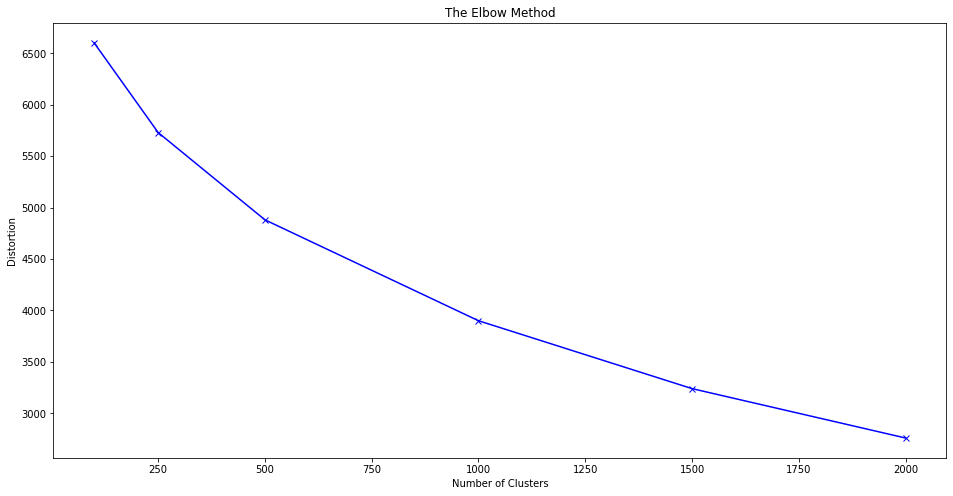

Computing silhouette score...
Computing silhouette score...
Computing silhouette score...
Computing silhouette score...
Computing silhouette score...
Computing silhouette score...


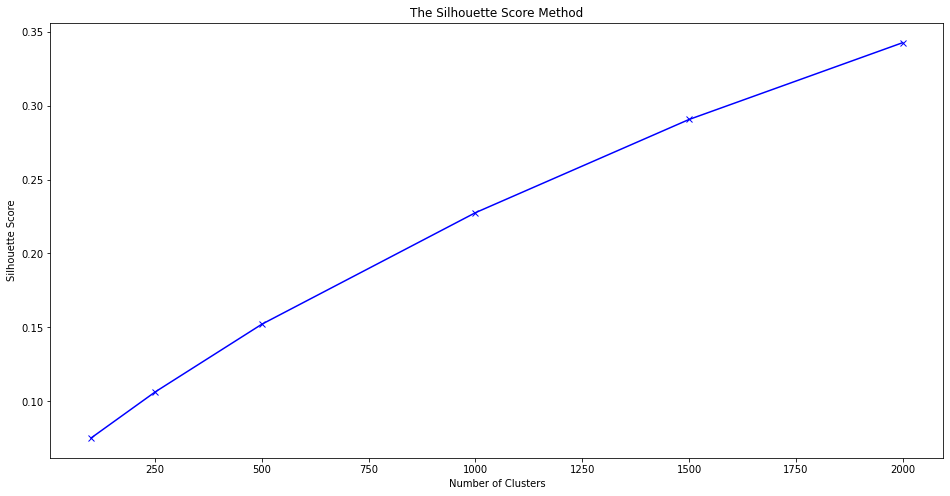

In [17]:
A = m2._model_obj.training_vectors[0]

print(A.shape)

import numpy as np
from sklearn.cluster import KMeans

kmeans_models = []
myseed = 1234
K = [100,250,500,1000,1500,2000] 
for num_clusters in K:
    print('Clustering started for %s clusters.' %num_clusters)
    kmeans = KMeans(n_clusters=num_clusters,random_state=myseed).fit(A)
    kmeans_models.append(kmeans)
    print('Clustering done for %s clusters.' %num_clusters)

distortions = []
for model in kmeans_models:
    distortions.append(model.inertia_)

import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()


from sklearn.metrics import silhouette_score

silhouette_scores = []
for model in kmeans_models:
    print('Computing silhouette score...')
    silhouette_scores.append(silhouette_score(A, model.labels_,random_state=myseed))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('The Silhouette Score Method')
plt.show()

In [18]:
narratives = m2.predict(postproc_roles, progress_bar = True)


Predicting entities for role: ARG0...
Matching known entities (with character matching)...


100%|██████████████████████████████████| 40765/40765 [00:02<00:00, 14239.14it/s]


Matching unknown entities (with embeddings distance)...
Computing phrase embeddings...


100%|████████████████████████████████████| 40765/40765 [01:18<00:00, 521.97it/s]


Assigning labels to matches...

Predicting entities for role: ARG1...
Matching known entities (with character matching)...


100%|██████████████████████████████████| 79931/79931 [00:05<00:00, 14102.67it/s]


Matching unknown entities (with embeddings distance)...
Computing phrase embeddings...


100%|████████████████████████████████████| 79931/79931 [03:10<00:00, 420.44it/s]


Assigning labels to matches...


In [19]:
pretty_narratives = []
for n in narratives: 
    if n.get('ARG0') is not None:
        if n.get('B-V') is not None:
            if n.get('ARG1') is not None:
                pretty_narratives.append(prettify(n))
                
pretty_narratives = Counter(pretty_narratives)
for t in pretty_narratives.most_common(10): print(t)

('you do what', 195)
('you have my complete endorsement', 89)
('you do job', 78)
('you do nothing', 60)
('you will make america|great', 55)
('you make america|great', 54)
('you get you', 49)
('you know you', 43)
('you do this', 38)
('you have decision', 35)


In [20]:
m3 = NarrativeModel(model_type = 'dynamic',
                   roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1'],
                   roles_with_known_entities = ['ARG0','ARG1'],
                   known_entities = top_known_entities,
                   assignment_to_known_entities = 'character_matching',
                   roles_with_unknown_entities = [['ARG0','ARG1']],
                   embeddings_model = nlp_model,
                   threshold = 0.5)    

m3.train(postproc_roles, progress_bar = True)

100%|██████████████████████████████████| 150213/150213 [04:14<00:00, 590.46it/s]


In [21]:
narratives = m3.predict(postproc_roles, progress_bar = True)


Predicting entities for role: ARG0...
Matching known entities (with character matching)...


100%|██████████████████████████████████| 40765/40765 [00:02<00:00, 15361.71it/s]


Matching unknown entities (with embeddings distance)...
Computing phrase embeddings...


100%|████████████████████████████████████| 40765/40765 [01:15<00:00, 543.44it/s]


Assigning labels to matches...

Predicting entities for role: ARG1...
Matching known entities (with character matching)...


100%|██████████████████████████████████| 79931/79931 [00:05<00:00, 14531.78it/s]


Matching unknown entities (with embeddings distance)...
Computing phrase embeddings...


100%|████████████████████████████████████| 79931/79931 [03:05<00:00, 430.89it/s]


Assigning labels to matches...


In [22]:
pretty_narratives = []
for n in narratives: 
    if n.get('ARG0') is not None:
        if n.get('B-V') is not None:
            if n.get('ARG1') is not None:
                pretty_narratives.append(prettify(n))
                
pretty_narratives = Counter(pretty_narratives)
for t in pretty_narratives.most_common(10): print(t)

('they do what', 74)
('they have my complete endorsement', 67)
('we will make america|great', 55)
('you do what', 52)
('we make america|great', 50)
('they do job', 46)
('we do what', 24)
('they ! have clue', 21)
('they do it', 20)
('they get it', 20)


In [23]:
m3._model_obj.vectors_unknown_entities[0].shape

(7187, 96)

In [24]:
m3._model_obj.vocab_unknown_entities[0]

{0: Counter({'our problem': 7,
          'problem': 143,
          'his problem': 3,
          'your problem': 8,
          'their problem': 3,
          'some her problem': 2,
          'problem building he': 2,
          'tribeca hotel room': 1,
          'its problem which there': 2,
          'world problem which': 1,
          'spending problem': 1,
          'problem that': 1,
          'work problem': 1,
          'all problem': 3,
          'problem our economy': 1,
          'this problem': 1,
          'crime problem': 2,
          'deal that time problem': 1,
          'time problem': 3,
          'its crime tax problem': 1,
          'problem lot': 1,
          'year problem': 1,
          'he problem': 1,
          'part problem': 1,
          'its problem': 1,
          'problem we': 1,
          'problem they': 2}),
 1: Counter({'patriots': 15, 'patriots who': 9, 'time patriots people': 1}),
 2: Counter({'our value': 9,
          'property value': 1,
          'dollar va

In [39]:
m3._model_obj.known_entities

['democrats',
 'obama',
 'china',
 'u s',
 'america',
 'trump',
 'american',
 'barackobama',
 'republicans',
 'the united states',
 'congress',
 'russia',
 'donald trump',
 'cnn',
 'republican',
 'iran',
 'florida',
 'dems',
 'democrat',
 'fbi',
 'mexico',
 'americans',
 'hillary',
 'senate',
 'hillary clinton',
 'foxnews',
 'pennsylvania',
 'usa',
 'vote',
 'biden',
 'joe biden',
 'washington',
 'iowa',
 'nbc',
 'mittromney',
 'house',
 'ohio',
 'north korea',
 'texas',
 'new york',
 'the white house',
 'state',
 'the republican party',
 'isis',
 'georgia',
 'us',
 'north carolina',
 'michigan',
 'israel',
 'california',
 'gop',
 'iraq',
 'syria',
 'wisconsin',
 'witch hunt',
 'new hampshire',
 'great',
 'scotland',
 'd c',
 'crooked hillary',
 'the fake news',
 'fox',
 'south carolina',
 'arizona',
 'nyc',
 'nancy pelosi',
 'whitehouse',
 'obamacare',
 'virginia',
 'ukraine',
 'border',
 'dem',
 'canada',
 'japan',
 'clinton',
 'military',
 'fake news',
 'ted cruz',
 'trump tower',
 

In [34]:
from relatio import build_graph, draw_graph

G = build_graph(
    narratives, 
    top_n = 100, 
    prune_network = True
)

draw_graph(
    G,
    notebook = False,
    show_buttons = False,
    width="1600px",
    height="1000px",
    output_filename = 'example.html'
    )

In [ ]:
# TO-DO:
# - sort counters for vocab